# 3교시 대비: **시계열(ARIMA + ML) 유형** 완전체 템플릿  
토이데이터 + 문제 + 모범답안 + 실무 해설 (복붙용)

## 🎯 평가 목적(공식)
- 실제 산업 데이터를 기반으로 **변수 예측(시계열)** 수행
- 데이터 특성(정상성/계절성) 이해, **지표 최적화**, (필요 시) 운영 정책 제시
- (가산) 해석/원인 추정(어떤 변수/구간이 영향?)

---

## ✅ 시계열 유형에서 시험이 요구하는 “정답 흐름”
1) 데이터 로딩/탐색: 기간, 결측, 추세/계절성 확인  
2) 전처리: 결측 보정, 이상치 처리, 시간 정렬/리샘플  
3) 정상성/차분 판단(ARIMA 핵심) + (선택) 계절성  
4) 모델링:
   - **ARIMA(또는 SARIMA)**  
   - (선택) **ML 기반 회귀(라그/롤링 피처)**: RF/XGB/Linear
5) 평가: MAE/RMSE (시계열은 시간순 split)  
6) 운영 정책(옵션): 예측 오차/예측값 상위 구간 경보  
7) 리포트: 예측값/오차 큰 구간 리스트

> 시험장에서 할 일: `CSV_PATH`, `time_col`, `target_col`, `cat_cols`만 바꾸면 대부분 그대로 동작합니다.


## 0) Imports & 재현성

In [15]:
import os, random, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")
SEED=42
random.seed(SEED)
np.random.seed(SEED)

# statsmodels: ARIMA
import statsmodels.api as sm


## 1) 토이 시계열 데이터 생성 (시험장에서는 CSV 로딩으로 대체)

### 컨셉
- 제조 라인의 일/시간 단위 KPI(예: 불량률, 에너지 사용량, 수율 손실, 장비 부하)
- 외생 변수(exogenous): 온도/습도/부하/에러 등
- 특징: 추세 + 주간 계절성 + 노이즈 + 일부 결측/이상치


In [16]:
def make_toy_timeseries(n_days=365*2, seed=42):
    rng=np.random.default_rng(seed)
    dates = pd.date_range("2023-01-01", periods=n_days, freq="D")

    # 외생 변수
    temp = 20 + 10*np.sin(2*np.pi*np.arange(n_days)/365) + rng.normal(0, 1.5, n_days)        # 연간 계절
    humidity = 45 + 8*np.sin(2*np.pi*np.arange(n_days)/30) + rng.normal(0, 2.0, n_days)      # 월간 흔들림
    load = 100 + 5*np.sin(2*np.pi*np.arange(n_days)/7) + rng.normal(0, 3.0, n_days)          # 주간 계절
    error_cnt = rng.poisson(2.0, n_days) + (rng.random(n_days) < 0.05)*rng.poisson(8, n_days) # 가끔 스파이크

    # 타깃: KPI (추세 + 주간 + 외생 영향 + 노이즈)
    trend = 0.02*np.arange(n_days)
    weekly = 3*np.sin(2*np.pi*np.arange(n_days)/7)
    y = (
        50 + trend + weekly
        + 0.6*error_cnt
        + 0.15*(load-100)
        + 0.25*(temp-20)
        + rng.normal(0, 2.0, n_days)
    )

    df = pd.DataFrame({
        "date": dates,
        "temp": temp,
        "humidity": humidity,
        "load": load,
        "error_cnt": error_cnt,
        "kpi": y
    })

    # 결측 주입(2%)
    miss = rng.random(n_days) < 0.02
    df.loc[miss, "kpi"] = np.nan

    # 이상치 주입(0.5%)
    out = rng.random(n_days) < 0.005
    df.loc[out, "kpi"] += rng.normal(25, 5, out.sum())

    return df

df = make_toy_timeseries()
df.head()


,date,temp,humidity,load,error_cnt,kpi
0,2023-01-01,20.457076,45.895627,102.888882,1,50.287032
1,2023-01-02,18.612157,46.779842,101.735324,1,53.161707
2,2023-01-03,21.469893,49.351371,102.313362,1,51.507047
3,2023-01-04,21.927044,49.326940,103.548537,5,54.159157
4,2023-01-05,17.761471,51.501446,100.796241,3,48.387540


## 2) (시험형) 문제 정의 — 시계열 예측 프로젝트

### 목표
- 과거 KPI 시계열 + 외생 변수로 **미래 KPI**를 예측
- ARIMA 구조(AR·I·MA), 정상성/계절성 고려
- MAE/RMSE로 평가하고, 운영 관점의 경보 정책(옵션)을 제시

### 요구사항(시험 단골)
1) 기간/결측/분포/추세·계절성 확인  
2) 결측/이상치 처리  
3) 정상성 고려(차분 여부 결정)  
4) ARIMA(또는 SARIMA) 학습/예측  
5) (선택) ML(라그/롤링 피처) 모델과 비교  
6) MAE/RMSE 평가  
7) (옵션) 리포트(예측 상위/오차 상위 구간)


## 3) 1번: 데이터 탐색(EDA)

Shape: (730, 6)
Date range: 2023-01-01 00:00:00 -> 2024-12-30 00:00:00

Missing ratio:
date         0.000000
temp         0.000000
humidity     0.000000
load         0.000000
error_cnt    0.000000
kpi          0.017808
dtype: float64


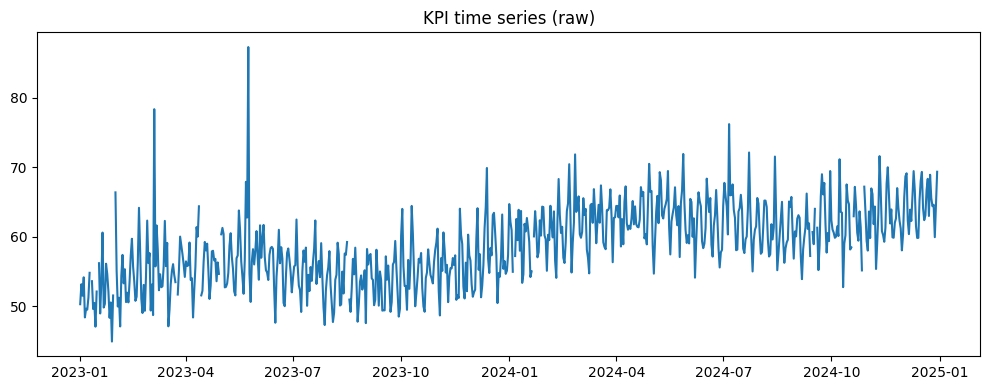

In [17]:
time_col="date"
target_col="kpi"
exog_cols=["temp","humidity","load","error_cnt"]

df = df.sort_values(time_col).reset_index(drop=True)

print("Shape:", df.shape)
print("Date range:", df[time_col].min(), "->", df[time_col].max())
print("\nMissing ratio:")
print(df.isna().mean())

plt.figure(figsize=(10,4))
plt.plot(df[time_col], df[target_col])
plt.title("KPI time series (raw)")
plt.tight_layout()
plt.show()


### 💡 실무 해설(EDA에서 뭘 보고 뭘 결정?)
- **추세/계절성**이 보이면 ARIMA에서 `d`(차분) 또는 계절항(SARIMA) 고려  
- 결측이 있으면:
  - 짧은 결측: 보간/전후값으로 메움
  - 긴 결측: 구간 제거 또는 별도 처리
- 이상치가 튀면:
  - winsorize(클리핑) / robust 모델 / 로그 변환 고려


## 4) 2번: 결측/이상치 처리 (안전한 기본형)

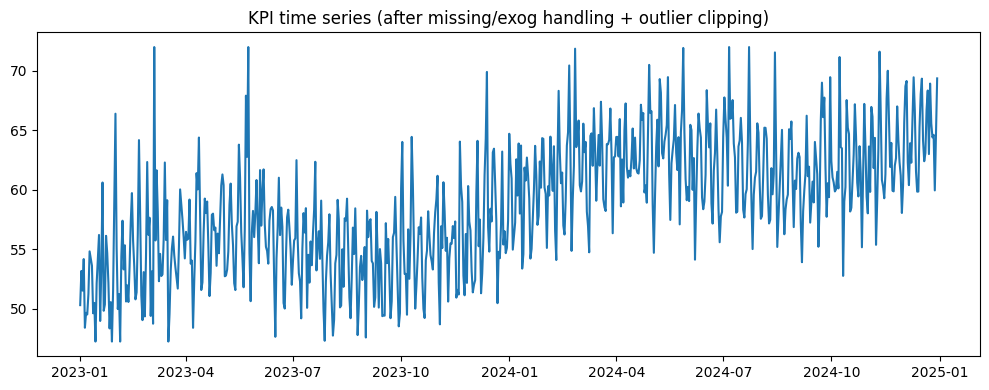

Any NaN left?
 kpi          False
temp         False
humidity     False
load         False
error_cnt    False
dtype: bool


In [18]:
df_proc = df.copy()

# ✅ (필수) time 컬럼 datetime 보장 + 정렬
df_proc[time_col] = pd.to_datetime(df_proc[time_col], errors="coerce")
df_proc = df_proc.sort_values(time_col).reset_index(drop=True)

# ✅ (권장) 시간 인덱스로 설정하면 time interpolation이 안전해짐
df_proc = df_proc.set_index(time_col)

# (1) 결측치 처리: 타깃 + 외생변수 모두 처리(외생에 NaN 있으면 SARIMAX가 깨질 수 있음)
cols_to_fill = [target_col] + exog_cols
for c in cols_to_fill:
    # 시간 기반 보간 (DatetimeIndex 필요)
    df_proc[c] = df_proc[c].interpolate(method="time")
    # 양끝 남는 결측은 ffill/bfill
    df_proc[c] = df_proc[c].ffill().bfill()

# (2) 이상치 처리: 간단 클리핑(상위 99.5% 이상은 컷) - 데이터 보고 켜기
USE_CLIP = True
if USE_CLIP:
    lo, hi = np.percentile(df_proc[target_col].values, [0.5, 99.5])
    df_proc[target_col] = df_proc[target_col].clip(lo, hi)

# 인덱스 복구(이후 코드에서 time_col 사용하기 쉽게)
df_proc = df_proc.reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_proc[time_col], df_proc[target_col])
plt.title("KPI time series (after missing/exog handling + outlier clipping)")
plt.tight_layout()
plt.show()

# ✅ sanity check
print("Any NaN left?\n", df_proc[[target_col]+exog_cols].isna().any())


## 5) 3번: 정상성(Stationarity) 체크 & 차분 결정 (ARIMA 핵심)

In [19]:
from statsmodels.tsa.stattools import adfuller

series = df_proc[target_col].values

def adf_test(x, name="series"):
    res = adfuller(x, autolag="AIC")
    print(f"[ADF] {name}: p-value={res[1]:.4f}")

adf_test(series, "raw")

# 1차 차분
diff1 = np.diff(series, n=1)
adf_test(diff1, "diff1")

# 2차 차분(필요 시)
diff2 = np.diff(series, n=2)
adf_test(diff2, "diff2")


[ADF] raw: p-value=0.7939
[ADF] diff1: p-value=0.0000
[ADF] diff2: p-value=0.0000


### 💡 실무 해설(정상성이 왜 중요?)
- ARIMA는 **평균/분산이 시간에 따라 크게 변하지 않는(정상)** 시계열에서 안정적으로 동작
- 추세가 있으면 차분(d=1)로 정상성에 가까워짐
- d를 과하게 주면 정보 손실/예측력 저하 → 최소 차분으로 p-value 개선되는 수준이 보통

> 시험에서는 ADF p-value를 '설명'까지 요구하진 않더라도,  
> **차분(d) 선택 근거**를 코드로 보여주면 가산점 요소입니다.


## 6) 4번: 시계열 Split (시간순 분리)

In [20]:
# 마지막 20%를 검증으로
n = len(df_proc)
split = int(n*0.8)

train = df_proc.iloc[:split].copy()
val = df_proc.iloc[split:].copy()

y_train = train[target_col].values
y_val = val[target_col].values

X_train_exog = train[exog_cols].values
X_val_exog = val[exog_cols].values

print("Train:", train.shape, "Val:", val.shape)


Train: (584, 6) Val: (146, 6)


## 7) 4번: ARIMA(외생변수 포함: SARIMAX 사용)

statsmodels의 `SARIMAX`는
- ARIMA(비계절)도 가능
- 외생변수(exog)도 같이 넣을 수 있음

### 파라미터 선택(시험장에서 현실적인 방식)
- `d`: ADF를 보고 0 또는 1 (대부분 1)
- `p,q`: 너무 오래 탐색하지 말고 0~2 범위에서 간단 Grid


In [21]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# 간단 탐색(작게)
d = 1  # ADF 기반으로 결정했다고 가정 (raw p가 크고 diff1이 개선되면 1)
pq_grid = [(0,0),(1,0),(0,1),(1,1),(2,1),(1,2)]

best = None
best_mae = 1e18
best_order = None
best_model = None

for p,q in pq_grid:
    try:
        model = sm.tsa.SARIMAX(
            y_train, exog=X_train_exog,
            order=(p,d,q),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = model.fit(disp=False)
        pred = fit.predict(start=0, end=len(y_val)-1, exog=X_val_exog)
        mae = mean_absolute_error(y_val, pred)
        if mae < best_mae:
            best_mae = mae
            best = pred
            best_order = (p,d,q)
            best_model = fit
    except Exception as e:
        continue

print("Best ARIMA order:", best_order, "MAE:", best_mae, "RMSE:", rmse(y_val, best))


Best ARIMA order: (1, 1, 0) MAE: 7.869988796408634 RMSE: 9.488047494267235


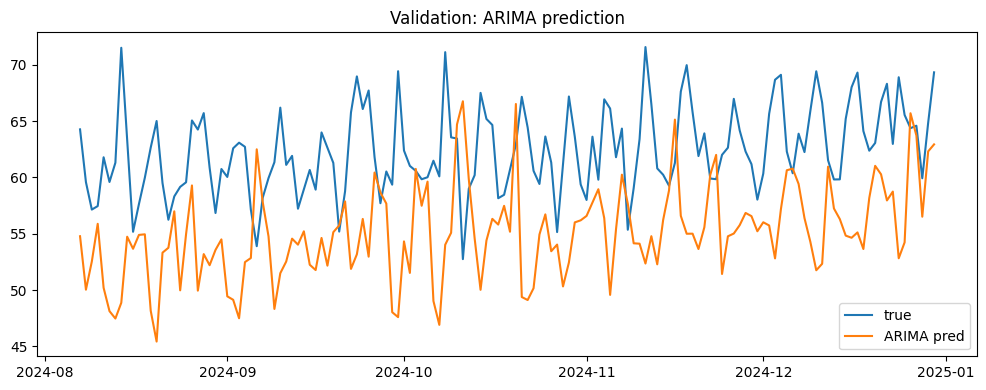

In [22]:
plt.figure(figsize=(10,4))
plt.plot(val[time_col], y_val, label="true")
plt.plot(val[time_col], best, label="ARIMA pred")
plt.title("Validation: ARIMA prediction")
plt.legend()
plt.tight_layout()
plt.show()


## 8) 5번(선택): ML 비교(라그/롤링 피처 기반 회귀)

ARIMA가 잘 안 맞는 경우(복잡한 비선형/외생 영향 큼)에는  
라그/롤링 피처로 ML 모델(RF/XGB 등)이 더 잘 맞을 수 있습니다.

### 안전한 피처
- lag 1, 7 (어제, 1주 전)
- rolling mean 7, 14
- 외생 변수 그대로 포함


In [23]:
def make_lag_features(df_in, target, exogs, lags=(1,7), rolls=(7,14)):
    df2 = df_in.copy()
    for l in lags:
        df2[f"lag_{l}"] = df2[target].shift(l)
    for r in rolls:
        df2[f"roll_mean_{r}"] = df2[target].shift(1).rolling(r).mean()
    # exogs already in df2
    feats = exogs + [f"lag_{l}" for l in lags] + [f"roll_mean_{r}" for r in rolls]
    df2 = df2.dropna().reset_index(drop=True)
    return df2, feats

df_feat, feat_cols = make_lag_features(df_proc, target_col, exog_cols)

# 시간순 split 다시
n2 = len(df_feat)
split2 = int(n2*0.8)
train2 = df_feat.iloc[:split2]
val2 = df_feat.iloc[split2:]

Xtr2 = train2[feat_cols].values
ytr2 = train2[target_col].values
Xva2 = val2[feat_cols].values
yva2 = val2[target_col].values

rf = RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1)
rf.fit(Xtr2, ytr2)
pred_rf = rf.predict(Xva2)

print("RF MAE:", mean_absolute_error(yva2, pred_rf), "RMSE:", rmse(yva2, pred_rf))


RF MAE: 2.157515289280008 RMSE: 2.7452995886887566


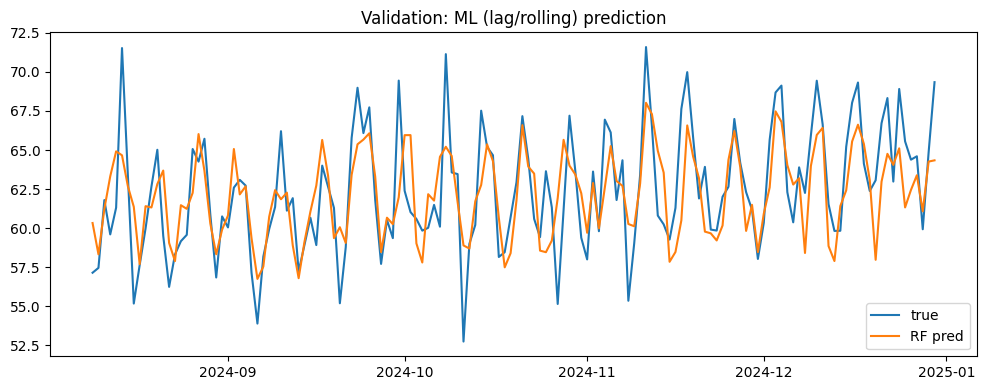

In [24]:
plt.figure(figsize=(10,4))
plt.plot(val2[time_col], yva2, label="true")
plt.plot(val2[time_col], pred_rf, label="RF pred")
plt.title("Validation: ML (lag/rolling) prediction")
plt.legend()
plt.tight_layout()
plt.show()


## 9) 6번: 모델 선택 & 최종 비교 요약

시험에서는 보통:
- ARIMA 결과(MAE/RMSE)
- (선택) ML 결과(MAE/RMSE)
를 같이 보여주면 “모델 선택 능력” 점수가 잘 나옵니다.


In [25]:
# ARIMA metrics
arima_mae = mean_absolute_error(y_val, best)
arima_rmse = rmse(y_val, best)

# RF metrics (if computed)
rf_mae = mean_absolute_error(yva2, pred_rf)
rf_rmse = rmse(yva2, pred_rf)

pd.DataFrame([
    ["ARIMA"+str(best_order), arima_mae, arima_rmse],
    ["RF(lag/roll)", rf_mae, rf_rmse],
], columns=["model","MAE","RMSE"]).sort_values("MAE")


,model,MAE,RMSE
1,RF(lag/roll),2.157515,2.745300
0,"ARIMA(1, 1, 0)",7.869989,9.488047


## 10) 7번(옵션): 운영 정책 & 리포트

시계열에서 운영 정책은 보통 2가지 형태로 나옵니다.

### (A) 예측값 기반 경보
- 예: KPI가 높으면 위험 → 예측 KPI 상위 Top 5% 날짜를 점검

### (B) 오차 기반 경보(모델 불확실/이상 이벤트 탐지)
- 실제-예측 오차가 큰 구간 = 비정상 이벤트/센서 오류 가능

아래는 RF 예측을 기준으로 두 리포트를 출력합니다.


In [26]:
# RF 기준 리포트
rep = val2[[time_col] + exog_cols + [target_col]].copy()
rep["pred"] = pred_rf
rep["abs_error"] = np.abs(rep[target_col] - rep["pred"])

# A) 예측값 Top 5%
th_pred = np.percentile(rep["pred"], 95)
rep["alarm_pred_top5"] = (rep["pred"] >= th_pred).astype(int)

# B) 오차 Top 5%
th_err = np.percentile(rep["abs_error"], 95)
rep["alarm_err_top5"] = (rep["abs_error"] >= th_err).astype(int)

print("Pred top5 alarm rate:", rep["alarm_pred_top5"].mean())
print("Error top5 alarm rate:", rep["alarm_err_top5"].mean())


Pred top5 alarm rate: 0.05555555555555555
Error top5 alarm rate: 0.05555555555555555


In [27]:
# 리포트 출력
print("=== Pred Top 5% (top 20) ===")
display(rep.sort_values("pred", ascending=False).head(20))

print("=== Error Top 5% (top 20) ===")
display(rep.sort_values("abs_error", ascending=False).head(20))


=== Pred Top 5% (top 20) ===


,date,temp,humidity,load,error_cnt,kpi,pred,abs_error,alarm_pred_top5,alarm_err_top5
666,2024-11-11,13.642106,37.234099,103.624261,4,71.587544,68.020746,3.566798,1,0
688,2024-12-03,13.818277,47.965895,108.778115,3,68.681322,67.472575,1.208747,1,0
667,2024-11-12,13.467907,41.851012,103.878134,4,66.523439,67.296792,0.773353,1,0
689,2024-12-04,15.432275,44.982967,104.069683,9,69.121547,66.803078,2.318469,1,0
702,2024-12-17,15.268055,43.706401,106.317726,2,69.319625,66.620016,2.699609,1,0
645,2024-10-21,10.115752,41.505060,106.226777,2,67.167043,66.591192,0.575851,1,0
673,2024-11-18,15.503125,42.288699,106.718865,2,69.982901,66.572732,3.410169,1,0
696,2024-12-11,16.604301,36.742545,99.616960,6,66.643042,66.417254,0.225788,1,0
681,2024-11-26,13.159358,50.105316,106.677517,3,66.986211,66.217151,0.769060,0,0
619,2024-09-25,7.143690,51.426282,104.625711,8,67.728433,66.070524,1.657909,0,0


=== Error Top 5% (top 20) ===


,date,temp,humidity,load,error_cnt,kpi,pred,abs_error,alarm_pred_top5,alarm_err_top5
624,2024-09-30,10.870175,55.447445,98.484725,2,69.441982,61.978723,7.463259,0,1
672,2024-11-17,14.315675,43.513389,97.171960,2,67.627792,60.497905,7.129887,0,1
577,2024-08-14,13.565820,36.270040,98.495304,14,71.523954,64.661966,6.861988,0,1
651,2024-10-27,8.445213,55.652838,100.579545,1,55.149436,61.923820,6.774384,0,1
579,2024-08-16,10.466525,33.918056,103.697676,1,55.176099,61.365995,6.189896,0,1
635,2024-10-11,9.569566,42.002064,95.759520,0,52.744483,58.894324,6.149841,0,1
632,2024-10-08,11.000663,44.448857,109.077285,5,71.135140,65.206733,5.928407,0,1
649,2024-10-25,10.345209,50.626707,95.328374,2,63.642927,58.462317,5.180610,0,1
705,2024-12-20,16.584312,42.150266,94.005134,1,63.065533,57.975515,5.090017,0,0
715,2024-12-30,18.148563,53.323091,105.556106,1,69.341256,64.338752,5.002504,0,0


## 11) 실무 엔지니어 플레이북: “데이터가 어떻다면 무엇을 선택?”

### A. 정상성이 안 맞는다(ADF p-value 높다)
- d=1 차분
- 여전히 안 되면 d=2(신중)
- 계절성이 보이면 SARIMA(계절차분 D=1) 고려

### B. 계절성이 강하다(주간/월간 반복)
- SARIMA(계절 항) 또는
- ML lag 피처에 계절 lag 추가(7, 14, 28)

### C. 외생 변수가 중요해 보인다
- SARIMAX(exog) 필수
- ML 모델에도 exog 포함

### D. 결측이 많다
- 짧은 결측: 보간 + ffill/bfill
- 긴 결측: 구간 제거/리샘플링 후 보간

### E. 이상치가 많다(센서 스파이크)
- 클리핑/robust 모델
- 오차 기반 경보 리포트로 “이상 이벤트 구간” 제시

### F. ARIMA 성능이 약하다
- 비선형/외생 영향이 크면 ML(lag/rolling)로 전환
- 반대로 ML이 흔들리면 ARIMA로 baseline 확보 후 앙상블 가능


## 11.5) 불균형·지표 최적화 심화 플레이북 (시계열 버전)

시계열은 분류처럼 “양성/음성” 불균형이 없더라도, 실무에서는 아래 형태로 **불균형**이 자주 등장합니다.

### 케이스 1) “상위 1~5%” 고손실/고위험 구간이 진짜 중요 (희귀 이벤트)
- 전체 MAE는 좋은데, **피크 구간만 계속 틀린다**
- 운영적으로는 피크를 놓치면 큰 비용

✅ 대응 아이디어
- **가중치 손실**(피크 구간에 샘플 가중치↑)
- **Quantile(분위수) 예측**(상단 리스크를 직접 모델링)
- **정책 기반 평가**(Top-N 구간에서 MAE/RMSE만 따로 계산)

### 케이스 2) 데이터가 매우 적다/짧다
- ARIMA가 더 안정적인 baseline
- ML은 lag 피처가 부족해 흔들릴 수 있음

### 케이스 3) 구조적 변화(개선/라인 변경)로 분포가 바뀜(Concept Drift)
- 최근 구간에 더 가중치 부여
- 롤링 재학습(최근 N일만 사용)

아래는 시험장에서 그대로 쓸 수 있는 “코드 스니펫” 모음입니다.


In [28]:
# =========================
# (1) Top-N 구간에서만 성능 평가(정책 기반 평가)
# =========================
def topk_mae(y_true, y_pred, top_pct=5):
    y_true = np.asarray(y_true); y_pred=np.asarray(y_pred)
    th = np.percentile(y_true, 100-top_pct)
    mask = y_true >= th
    return mean_absolute_error(y_true[mask], y_pred[mask])

print("ARIMA Top5% MAE:", topk_mae(y_val, best, top_pct=5))
print("RF   Top5% MAE:", topk_mae(yva2, pred_rf, top_pct=5))

# =========================
# (2) 피크 구간 가중치(샘플 가중치)로 ML 학습
# =========================
# 피크(상위 10%)에 가중치 3배
th_peak = np.percentile(ytr2, 90)
w = np.ones_like(ytr2, dtype=float)
w[ytr2 >= th_peak] = 3.0

rf_w = RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1)
rf_w.fit(Xtr2, ytr2, sample_weight=w)
pred_rf_w = rf_w.predict(Xva2)

print("RF(weighted) MAE:", mean_absolute_error(yva2, pred_rf_w), "Top5% MAE:", topk_mae(yva2, pred_rf_w, 5))

# =========================
# (3) Drift 대응: 최근 구간 가중치(최근일수록 weight↑)
# =========================
# 간단 예시: 최신으로 갈수록 선형 가중치
t = np.linspace(1.0, 2.0, len(ytr2))
rf_drift = RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1)
rf_drift.fit(Xtr2, ytr2, sample_weight=t)
pred_rf_drift = rf_drift.predict(Xva2)
print("RF(drift-weighted) MAE:", mean_absolute_error(yva2, pred_rf_drift))


ARIMA Top5% MAE: 16.764709840194584
RF   Top5% MAE: 4.800368351896194
RF(weighted) MAE: 2.161532953321616 Top5% MAE: 4.804771305775754
RF(drift-weighted) MAE: 2.160947954687634


## 12) 시험장 복붙 체크리스트(시계열)
1) `time_col`, `target_col`, `exog_cols` 설정  
2) 날짜 정렬 + 결측 처리  
3) 시간순 split  
4) SARIMAX(ARIMA) 학습 & MAE/RMSE  
5) (선택) lag/rolling ML 비교  
6) (옵션) Top-N 리포트 1~2개 출력  
